# Trabalho da disciplina Projeto/MVP em Ciência de Dados

## Aluno: Luis Eduardo Ribeiro Veiga - RA: 40520223000855

## Notebook modelo Deep Learning - Classificador de imagens do dataset CIFAR10

**Descrição do Problema** - Criar um modelo de visão computacional para classificar uma imagem em alguma das categorias presentes no dataset CIPHAR10.

**Dataset** - O dataset CIFAR-10 é composto por 60000 imagens a cores 32x32 em 10 classes, com 6000 imagens por classe. Existem 50000 imagens de treino e 10000 imagens de teste. 

As classes presentes no dataset são: airplane, automobile, bird, cat, deer, dog, frog, horse, ship e truck.

### Importação de bibliotecas

In [31]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Verifica disponibilidade de GPU

In [32]:
gpu_dev_name = tf.test.gpu_device_name()
if gpu_dev_name != '/device:GPU:0':
  print('GPU não encontrada')
else:
    print('GPU encontrada em: {}'.format(gpu_dev_name))

GPU não encontrada


### Funções utilitárias

In [33]:
# Prepara dataframe com os dados lidos a partir do dataset CIFAR10 
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)

# Cria arquivos nos diretórios de trabalho com as imagens contidas no dataset CIFAR10
def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)

# Cria os diretórios de trabalho usados no processamento do código no notebook
def create_directory(dir):
    if os.path.exists(dir):
        # for file in os.listdir(dir):
        #     os.remove(dir+file)
        delete_files(dir)
    else:
        os.makedirs(dir)

# Exclui arquivos em diretório
def delete_files(dir):
    for file in os.listdir(dir):
        os.remove(dir+file)

# Plota gráfico com a evolução do valor loss em função da época
def plot_loss(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss X epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Plota gráfico com a evolução do valor accuracy em função da época
def plot_accuracy(history):  
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy X epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Plota matriz de confusão
def plot_confusion_matrix(actual, predicted, class_names):
    cnf_matrix = confusion_matrix(actual, predicted, labels=class_names)
    np.set_printoptions(precision=2)

    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(cnf_matrix, cmap=plt.cm.Blues, alpha=0.3, interpolation = 'nearest')
    plt.gca().xaxis.tick_bottom()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center')

    fig.colorbar(cax)

    plt.xlabel('Predição', fontsize=13)
    plt.ylabel('Real', fontsize=13)
    plt.title('Matriz de Confusão', fontsize=18)
    plt.show()

# Define configuração do modelo 1
def model1(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model1 = models.Sequential()

    model1.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Flatten())
    model1.add(layers.Dense(512, activation='relu'))
    model1.add(layers.Dense(10, activation='softmax'))
    
    loss, accuracy = execute_model(model1, p_train_generator, p_valid_generator, p_test_generator, p_train_step_size, p_validation_step_size, p_epochs)

    return model1, loss, accuracy

# Define configuração do modelo 2
def model2(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model2 = models.Sequential()

    model2.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Flatten())
    model2.add(layers.Dense(512, activation='relu'))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(10, activation='softmax'))

    loss, accuracy = execute_model(model2, p_train_generator, p_valid_generator, p_test_generator, p_train_step_size, p_validation_step_size, p_epochs)

    return model2, loss, accuracy

# Define configuração do modelo 3
def model3(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model3 = models.Sequential()

    model3.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Flatten())
    model3.add(layers.Dense(512, activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.Dropout(0.25))
    model3.add(layers.Dense(10, activation='softmax'))

    loss, accuracy = execute_model(model3, p_train_generator, p_valid_generator, p_test_generator, p_train_step_size, p_validation_step_size, p_epochs)

    return model3, loss, accuracy

# Define configuração do modelo 4
def model4(p_train_generator, p_test_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    model4 = models.Sequential()

    model4.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Flatten())
    model4.add(layers.Dense(512, activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.Dense(10, activation='softmax'))

    loss, accuracy = execute_model(model4, p_train_generator, p_valid_generator, p_test_generator, p_train_step_size, p_validation_step_size, p_epochs)

    return model4, loss, accuracy

# Executa modelo
def execute_model(p_model, p_train_generator, p_valid_generator, p_test_generator, p_train_step_size, p_validation_step_size, p_epochs):
    p_model.summary()
    
    history = compile_fit_model(p_model, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs)

    loss, accuracy = display_result_model (p_model, p_test_generator, history)

    return loss, accuracy

# Processa a compilação e a função fit em um modelo
def compile_fit_model(p_model, p_train_generator, p_valid_generator, p_train_step_size, p_validation_step_size, p_epochs):
    p_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = p_model.fit_generator(generator=p_train_generator,
          validation_data=p_valid_generator,
          steps_per_epoch=p_train_step_size,
          validation_steps=p_validation_step_size,
          epochs=p_epochs)
    
    return history

# Apresenta resultados do processamento de determinada operação no modelo
def display_result_model (p_model, p_test_generator, p_history):
    plot_loss(p_history)
    plot_accuracy(p_history)

    loss, accuracy = p_model.evaluate_generator(p_test_generator)
    print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

    return loss, accuracy

# Plota informações sobre um dataset
def plot_dataset_class(p_dataset, p_title):
    print((p_dataset['label']).value_counts())
    p_dataset['label'].value_counts().plot.bar(title=p_title)


### Carga e preparação dos dados

Carrega o dataset, separa entre treino e teste e monta a lista de classes das imagens.

In [34]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Cria os diretórios de trabalho.

In [35]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

Define o tamanho das amostras de treino e teste usadas no processamento do notebook.

In [36]:
v_train_samples = 1000 
v_test_samples = 200 
# v_train_samples = X_train.shape[0]
# v_test_samples = X_test.shape[0]

Cria os arquivos de imagens de treinamento nos diretórios de trabalho e prepara o dataframe de treinamento usado no processamento do notebook.

In [37]:
train_samples = v_train_samples

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


Cria os arquivos de imagens de teste nos diretórios de trabalho e prepara o dataframe de teste usado no processamento do notebook.

In [38]:
test_samples = v_test_samples

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


Apresenta informações sobre os dados de treinamento.

label
automobile    112
frog          107
truck         103
horse         102
airplane      102
deer           99
bird           99
ship           99
cat            92
dog            85
Name: count, dtype: int64


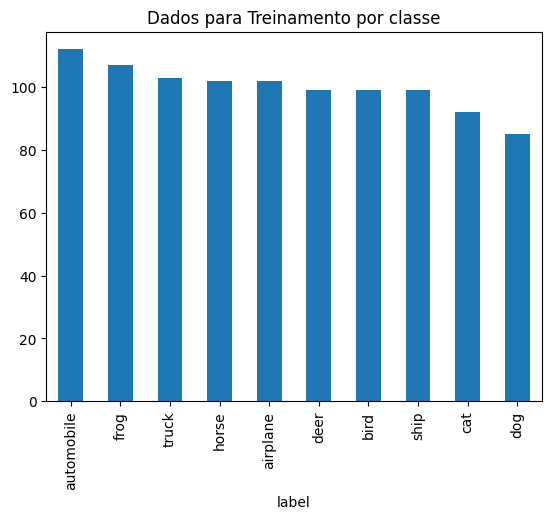

In [39]:
plot_dataset_class(train_df, 'Dados para Treinamento por classe')

Apresenta informações sobre os dados de teste.

label
ship          28
frog          26
truck         21
bird          21
airplane      20
cat           19
dog           18
horse         18
deer          15
automobile    14
Name: count, dtype: int64


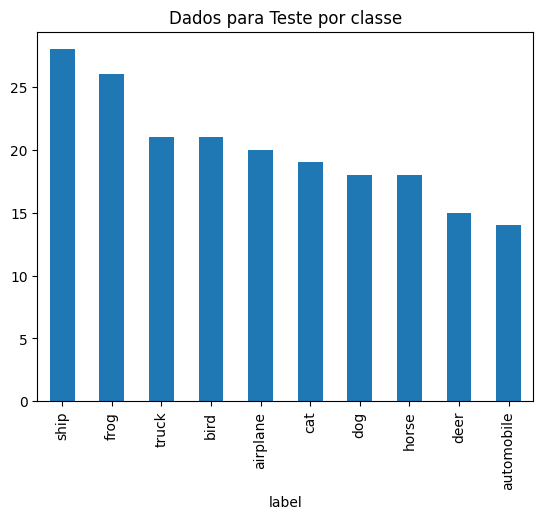

In [40]:
plot_dataset_class(test_df, 'Dados para Teste por classe')

Apresenta o total de imagens nos diretórios de treinamento e de teste.

In [41]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 1000
Total de imagens para teste      : 200


Apresenta algumas imagens do dataset de treinamento.

Classes: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


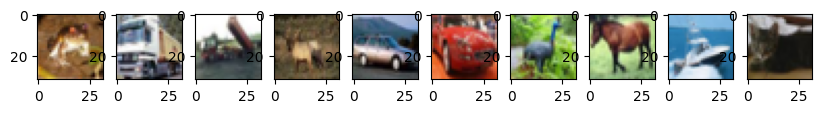

In [42]:
fig, x = plt.subplots(1, 10)
fig.set_size_inches(10, 10)

print('Classes: ' + str([cifar10_classes[x[0]] for x in y_train[0:10]]))

for i in range(10):
    image = X_train[i]
    x[i].imshow(image)

plt.show()

### Pré-processamento dos dados

Utilizamos a classe **keras.preprocessing.image.ImageDataGenerator** que permite configurar transformações e operações de normalização nas imagens durante o treinamento, assim como instânciar batches de imagens aumentadas. Essas operações reduzem o overfitting e generalizam melhor o modelo.

Configuramos o **ImageDataGenerator** para separar um conjunto de validação com 25% das amostras do conjunto de treino.

In [43]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'                                
                                )

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 750 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


Configuração dos dados de teste.

In [44]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 200 validated image filenames belonging to 10 classes.


### Modelagem e treinamento

Configura parâmetros usados no processo de treinamento.

In [45]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

v_epochs = 30

**Configuração dos Modelos**

Foram configurados 4 modelos candidatos para o treinamento da rede. O modelo que tiver a melhor acurácia será o escolhido para o treinamento da rede.

**Modelo 1**

Este modelo apresenta uma construção com 4 camadas convolucionais. Sendo uma com 32 filtros, outra com 64 e duas com 128 filtros. Essas camadas tem um kernel de tamanho 3x3 e usam a ativição 'ReLU'. 
O modelo também tem camadas max-pooling com bloco 2×2.
A primeira camada convolucional recebe uma imagem 32x32.

Na sequência temos uma camada 'Flatten', seguida de duas camadas densas. Na última camada densa é usada a função de ativação 'Softmax' para a classificação do conjunto de imagens de acordo com a sua classe. 

    model1 = models.Sequential()

    model1.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model1.add(layers.Flatten())
    model1.add(layers.Dense(512, activation='relu'))
    model1.add(layers.Dense(10, activation='softmax'))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 128)        

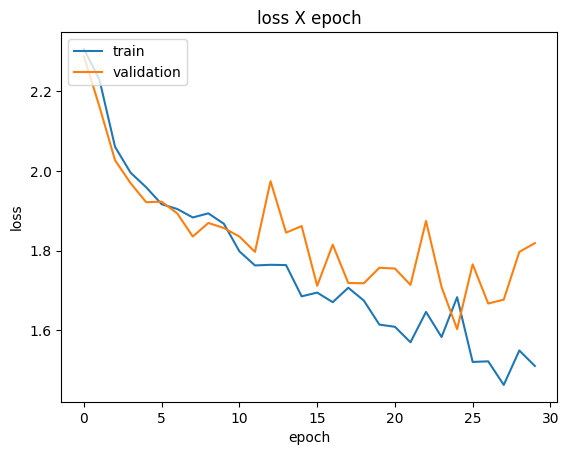

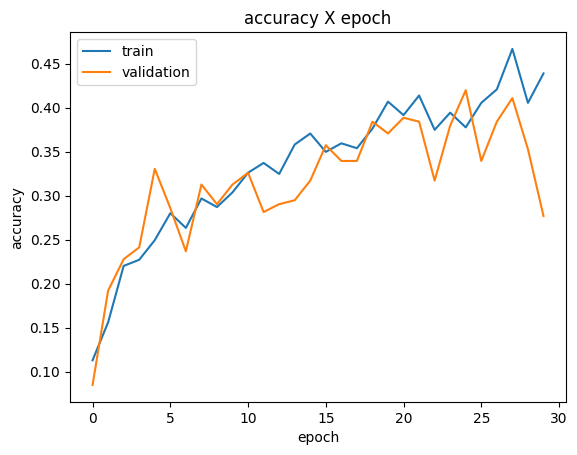

Test: accuracy = 0.385000  ;  loss = 1.712134 


In [46]:
model1, loss1, accuracy1 = model1(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

**Modelo 2**

O Modelo 2 é baseado na arquitetura do Modelo 1. Nele foram acrescentadas algumas camadas de 'Dropout' com um percentual de 25%. O objetivo dessas camadas é reduzir o overfitting no treinamento.

    model2 = models.Sequential()

    model2.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.Dropout(0.25))

    model2.add(layers.Flatten())
    model2.add(layers.Dense(512, activation='relu'))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(10, activation='softmax'))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                 

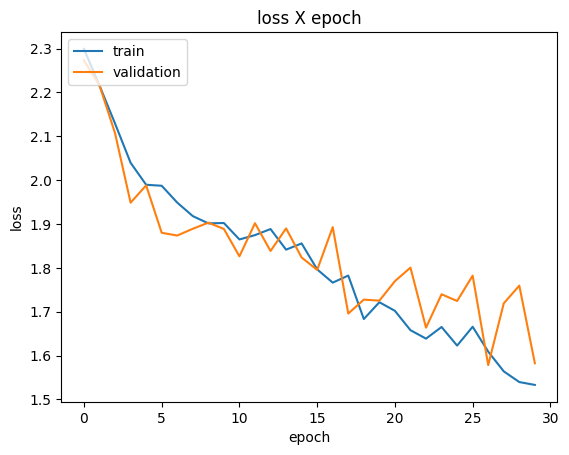

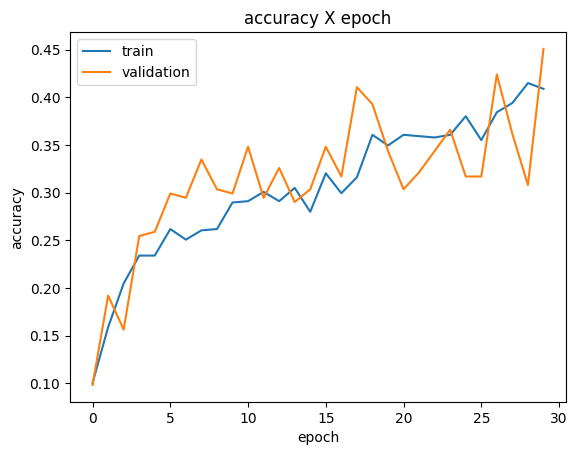

Test: accuracy = 0.400000  ;  loss = 1.649231 


In [47]:
model2, loss2, accuracy2 = model2(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

**Modelo 3**

No Modelo 3 parte-se da configuração do Modelo 2 e são acrescentadas algumas camadas 'BatchNormalization'. A normalização da saída da camada vai aumentar a velocidade do treinamento e melhorar a performance do modelo.

    model3 = models.Sequential()

    model3.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Dropout(0.25))

    model3.add(layers.Flatten())
    model3.add(layers.Dense(512, activation='relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.Dropout(0.25))
    model3.add(layers.Dense(10, activation='softmax'))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 128)      

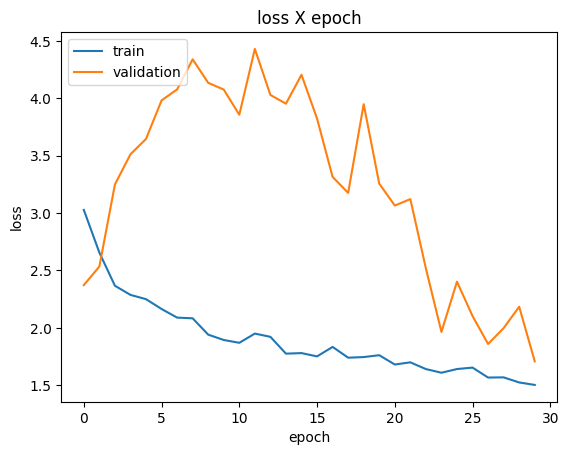

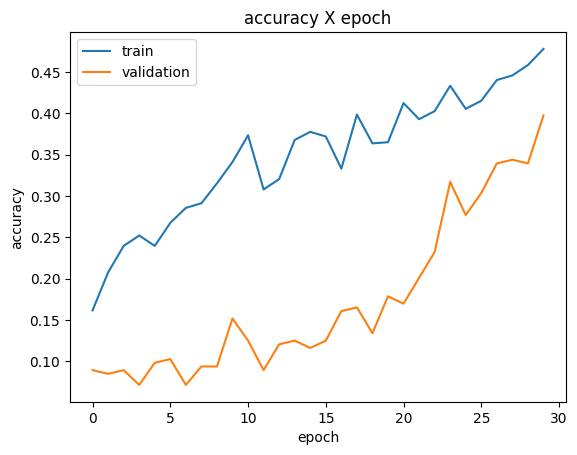

Test: accuracy = 0.420000  ;  loss = 1.829502 


In [48]:
model3, loss3, accuracy3 = model3(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

**Modelo 4**

No Modelo 4 são retiradas as camadas de 'Dropout' do Modelo 3 e foi mantido o restante de sua configuração.

    model4 = models.Sequential()

    model4.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

    model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model4.add(layers.Flatten())
    model4.add(layers.Dense(512, activation='relu'))
    model4.add(layers.BatchNormalization())
    model4.add(layers.Dense(10, activation='softmax'))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 12, 12, 128)     

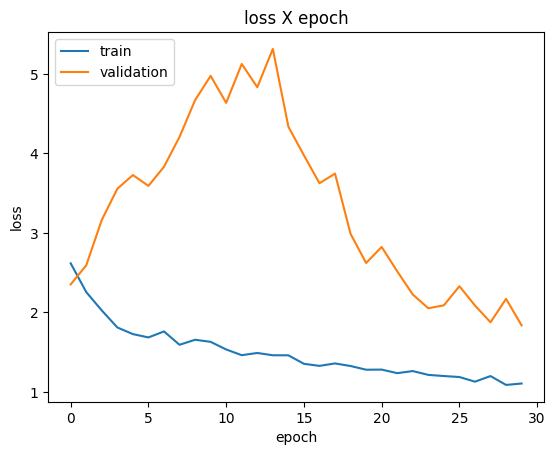

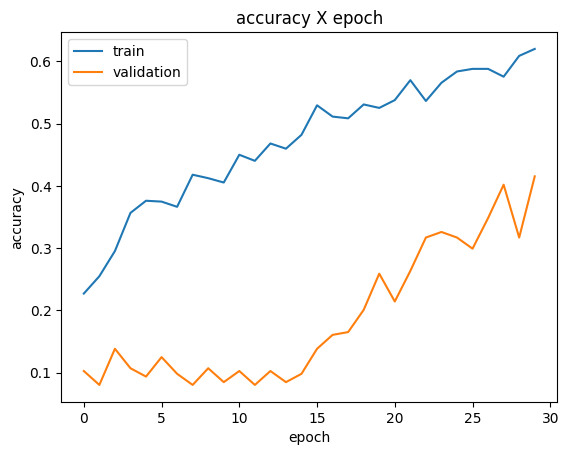

Test: accuracy = 0.395000  ;  loss = 1.926022 


In [49]:
model4, loss4, accuracy4 = model4(train_generator, test_generator, valid_generator, train_step_size, validation_step_size, v_epochs)

### Resultado da execução do treinamento dos modelos

In [50]:
print('Resultado dos Modelos')
print('---------------------------')
table_result_model = [[accuracy1, loss1], [accuracy2, loss2], [accuracy3, loss3], [accuracy4, loss4]]
df_result_model = pd.DataFrame(table_result_model, columns = ['accuracy', 'loss'], index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])
print(df_result_model)

Resultado dos Modelos
---------------------------
         accuracy      loss
Model 1     0.385  1.712134
Model 2     0.400  1.649231
Model 3     0.420  1.829502
Model 4     0.395  1.926022


In [51]:
model_accuracy = {
    'model1': accuracy1,
    'model2': accuracy2,
    'model3': accuracy3,
    'model4': accuracy4
}

model_selec = max(model_accuracy, key=model_accuracy.get)

print('Modelo escolhido: ' + model_selec)

if model_selec == 'model1':
    model = model1
elif model_selec == 'model2':
    model = model2
elif model_selec == 'model3':
    model = model3
else:
    model = model4

Modelo escolhido: model3


### Execução do modelo com o conjunto de teste

Executando a predição.

In [52]:
test_generator.reset()
pred=model.predict_generator(test_generator)

Resultado da avaliação do modelo.

In [53]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.420000  ;  loss = 1.829502 


Métricas da performance do modelo com as imagens de teste.

In [54]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

test_generator.reset()

count = 0
actuals = list()

for batch in test_generator:
    count+=1
    if count == len(test_generator)+1:
        break
    else:
        images = batch[0]
        labels = batch[1]
        for i in range(len(images)):
            label = labels[i]
            labeled_class = np.argmax(label)
            label = cifar10_classes[int(labeled_class)]
            actuals.append(label)

accuracy = skm.accuracy_score(actuals, predictions)
precision = skm.precision_score(actuals, predictions, average='weighted')
recall = skm.recall_score(actuals, predictions, average='weighted')
f1score = skm.f1_score(actuals, predictions, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.42
Precision:  0.46186821677823675
Recall:  0.42
F1 Score:  0.39142088944173864


Matriz de Confusão.

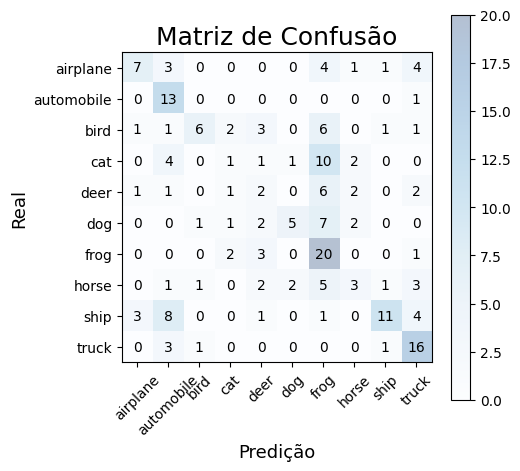

In [55]:
plot_confusion_matrix(actuals, predictions, cifar10_classes)

### Exportação do modelo

Salvando o modelo selecionado.

In [56]:
model_dir = "./trained_models/"
create_directory(model_dir)

model_name = 'trained_model_deep_learning.h5'

model.save("%s/%s" % (model_dir, model_name))
print("Modelo salvo com o nome: ", model_name)

Modelo salvo com o nome:  trained_model_deep_learning.h5


### Teste do modelo exportado

Carregando o modelo salvo.

In [57]:
model_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))
print("Modelo %s carregado com sucesso" % (model_name))

Modelo trained_model_deep_learning.h5 carregado com sucesso


Execução do modelo salvo com um subconjunto do dataset de teste

1/1 [==============================] - 0s 129ms/step


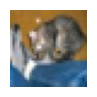

Label:  cat
Previsão:  frog
Probabilidade:  0.39025843


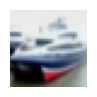

Label:  ship
Previsão:  automobile
Probabilidade:  0.9427146


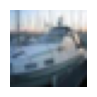

Label:  ship
Previsão:  automobile
Probabilidade:  0.44291753


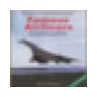

Label:  airplane
Previsão:  automobile
Probabilidade:  0.44599682


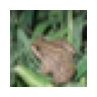

Label:  frog
Previsão:  frog
Probabilidade:  0.51901954


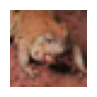

Label:  frog
Previsão:  frog
Probabilidade:  0.88316625


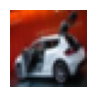

Label:  automobile
Previsão:  automobile
Probabilidade:  0.63306177


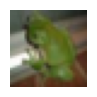

Label:  frog
Previsão:  deer
Probabilidade:  0.55097353


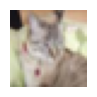

Label:  cat
Previsão:  deer
Probabilidade:  0.3379257


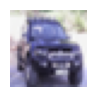

Label:  automobile
Previsão:  automobile
Probabilidade:  0.56705874


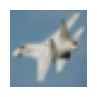

Label:  airplane
Previsão:  airplane
Probabilidade:  0.35004058


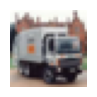

Label:  truck
Previsão:  truck
Probabilidade:  0.7488312


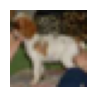

Label:  dog
Previsão:  frog
Probabilidade:  0.72000235


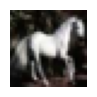

Label:  horse
Previsão:  automobile
Probabilidade:  0.5218031


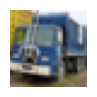

Label:  truck
Previsão:  truck
Probabilidade:  0.5950255


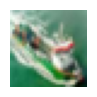

Label:  ship
Previsão:  frog
Probabilidade:  0.3937636


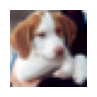

Label:  dog
Previsão:  dog
Probabilidade:  0.42802545


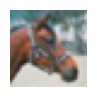

Label:  horse
Previsão:  frog
Probabilidade:  0.33741173


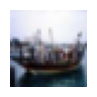

Label:  ship
Previsão:  automobile
Probabilidade:  0.57729924


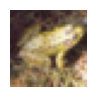

Label:  frog
Previsão:  frog
Probabilidade:  0.6673576


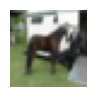

Label:  horse
Previsão:  truck
Probabilidade:  0.6335326


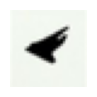

Label:  airplane
Previsão:  airplane
Probabilidade:  0.8785009


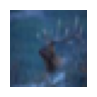

Label:  deer
Previsão:  airplane
Probabilidade:  0.39128897


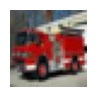

Label:  truck
Previsão:  truck
Probabilidade:  0.67263687


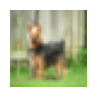

Label:  dog
Previsão:  deer
Probabilidade:  0.29915643


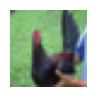

Label:  bird
Previsão:  frog
Probabilidade:  0.4925476


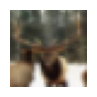

Label:  deer
Previsão:  cat
Probabilidade:  0.3716857


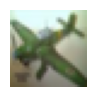

Label:  airplane
Previsão:  frog
Probabilidade:  0.48290285


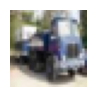

Label:  truck
Previsão:  automobile
Probabilidade:  0.6069673


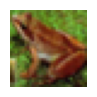

Label:  frog
Previsão:  frog
Probabilidade:  0.90234697


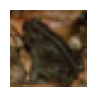

Label:  frog
Previsão:  cat
Probabilidade:  0.76148796


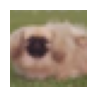

Label:  dog
Previsão:  bird
Probabilidade:  0.32078773
1/1 [==============================] - 0s 44ms/step


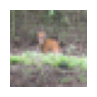

Label:  deer
Previsão:  frog
Probabilidade:  0.37533477


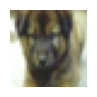

Label:  dog
Previsão:  frog
Probabilidade:  0.6415897


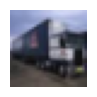

Label:  truck
Previsão:  truck
Probabilidade:  0.8734348


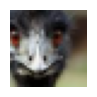

Label:  bird
Previsão:  truck
Probabilidade:  0.40766692


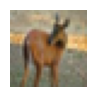

Label:  deer
Previsão:  frog
Probabilidade:  0.40373188


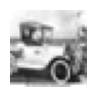

Label:  automobile
Previsão:  automobile
Probabilidade:  0.6774418


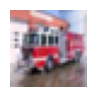

Label:  truck
Previsão:  truck
Probabilidade:  0.52535355


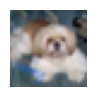

Label:  dog
Previsão:  deer
Probabilidade:  0.2822083


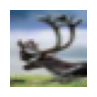

Label:  deer
Previsão:  automobile
Probabilidade:  0.5926606


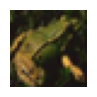

Label:  frog
Previsão:  frog
Probabilidade:  0.70448035


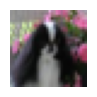

Label:  dog
Previsão:  dog
Probabilidade:  0.54512626


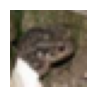

Label:  frog
Previsão:  frog
Probabilidade:  0.84075046


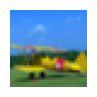

Label:  airplane
Previsão:  airplane
Probabilidade:  0.70307815


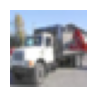

Label:  truck
Previsão:  truck
Probabilidade:  0.684465


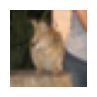

Label:  cat
Previsão:  frog
Probabilidade:  0.58255416


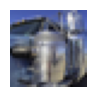

Label:  truck
Previsão:  truck
Probabilidade:  0.379385


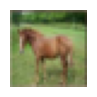

Label:  horse
Previsão:  deer
Probabilidade:  0.79786575


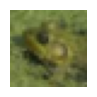

Label:  frog
Previsão:  frog
Probabilidade:  0.53674775


In [58]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()

img_count = 0
max_img = 50

for batch in test_generator:
    count+=1

    if count == len(test_generator)+1 or img_count > max_img:
        break

    else:
        images = batch[0]
        labels = batch[1]

        predictions = model_loaded.predict(images)

        for i in range(len(images)):
            img_count+=1

            if img_count > max_img:
                break
            else:
                image = images[i]
                label = labels[i]

                prediction = predictions[i]

                predicted_class = np.argmax(prediction)
                probability = prediction[predicted_class]
                class_name = cifar10_classes[int(predicted_class)]

                labeled_class = np.argmax(label)
                label = cifar10_classes[int(labeled_class)]

                y_true.append(label)
                y_pred.append(class_name)
                
                fig, x = plt.subplots(1, 1)
                fig.set_size_inches(1, 1)

                plt.imshow(images[i])
                plt.axis('Off')
                plt.show()
                
                print("Label: ", label)
                print("Previsão: ", class_name) 
                print("Probabilidade: ", probability) 

### Sumário

Dos modelos considerados no trabalho o que obteve a melhor acurácia foi o modelo 4. Ele se mostrou melhor que o modelo 3 que é um modelo que além das camadas convolucionais e densas também tem as camadas Dropout e BatchNormalization. No modelo 4 foi retirada a camada Dropout, isso melhorou a acurácia do modelo mas como esperado aumentou o overfitting.